<a href="https://colab.research.google.com/github/liao961120/cilin/blob/main/etc/radical_semantic_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Install dependencies
!pip install -q CompoTree
!pip install -q cilin
!pip install -q opencc

# Download font
!wget 'https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKtc-hinted.zip'
!mkdir /tmp/fonts
!unzip -qo NotoSansCJKtc-hinted.zip -d /tmp/fonts/
!mv /tmp/fonts/NotoSansMonoCJKtc-Regular.otf /usr/share/fonts/truetype/NotoSansMonoCJKtc-Regular.otf -f
!rm -rf /tmp/fonts
!rm NotoSansCJKtc-hinted.zip

# Download data
!wget -q https://github.com/liao961120/cilin/archive/refs/heads/main.zip
!unzip -q main.zip
!mv cilin-main/etc/* .

     |████████████████████████████████| 1.3 MB 26.0 MB/s 
     |████████████████████████████████| 600 kB 10.4 MB/s 
     |████████████████████████████████| 766 kB 14.4 MB/s 
--2021-12-18 11:48:58--  https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKtc-hinted.zip
Resolving noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)... 172.217.0.48, 2607:f8b0:4004:800::2010
Connecting to noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)|172.217.0.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121247366 (116M) [application/zip]
Saving to: ‘NotoSansCJKtc-hinted.zip’

NotoSansCJKtc-hinte 100%[===================>] 115.63M   104MB/s    in 1.1s    

2021-12-18 11:48:59 (104 MB/s) - ‘NotoSansCJKtc-hinted.zip’ saved [121247366/121247366]



In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager  

# Set chinese font for plotting
font_dirs = ['/usr/share/fonts/truetype/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    try:
        font_manager.fontManager.addfont(font_file)
    except: pass
plt.rcParams['font.family'] = "Noto Sans Mono CJK TC"

In [4]:
import json
import numpy as np
import pandas as pd
from cilin import Cilin
from CompoTree import Radicals
from collections import Counter
from itertools import product, chain
from random import sample
from utils import *

C = Cilin(trad=True)
def all_words():
    return chain.from_iterable(C.category_split().values())

## 同義詞詞林

<img src="https://github.com/liao961120/cilin/raw/main/etc/cilin_encoding.png" width=59% style="display:inlin-block">

<img src="https://github.com/liao961120/cilin/raw/main/etc/cilin_hierarchy.png" width=40% style="display:inlin-block">


## One-Character Words

### EDA

In [5]:
Tagger = RadicalSemanticTagger(all_words=all_words(), bigram=True, word_type="single")
DTM = DocumentTermMatrix(RSTagger=Tagger, Cilin=C, level=1)
rows = [C.get_tag(x) for x in DTM.documents]
columns = DTM.features
print(DTM.count_mat.shape)
DTM.count_mat

(12, 23)


array([[ 30,  36,  52,   0,  15,   2,   3,  17,   9,   0,   5,   4,   2,
          8,  18,   4,  25,  19,   7,   1,   7,   0,   1],
       [ 92,  17,  12,   9, 117,   4,   3,  69,  79,  12,  33,  49,  15,
         33, 379,  27, 406,  35,  52,   5, 101, 156,  10],
       [ 21,   8,   3,   1,  17,   0,   1,  13,  23,   1,  19,   0,   2,
          7,  21,   3,  64,  13,   1,   1,   7,   2,   1],
       [167,  69,  21,   1,  91,   4,  29,  58,  47,   1,  66,  22,   9,
         31, 123,  34, 191,  50,  24,  12,  56,  34,  13],
       [ 84,  57,  23,   2,  71,   3,  38,  43,  38,   3,  26,  21,   5,
         15,  64,  27, 207,  55,  19,  15,  40,  25,  17],
       [ 31,  16,   1,   0, 224,   3,   3, 101,  18,   2,   4,   9,   3,
         12,  28,  35,  88,  67,  11,   7,  24,   6,   3],
       [ 37,  15,   6,   0,  28,   0,  68,  19,   7,   3,   6,   5,   1,
          3,   9,   2,  96,  15,   5,   4,   3,   3,   1],
       [148,  60,  20,   1, 204,   8,  20,  67,  31,   2,  23,  20,   7,
   

In [6]:
def heatmap(mat):
    if isinstance(mat, np.ndarray):
        dfT = pd.DataFrame(mat, index=rows, columns=columns)
    else:
        dfT = mat
    ax = sns.heatmap(dfT, xticklabels=True, linewidths=0.01, linecolor='white', 
                     annot=True, fmt='.2f', cbar=False,
                     cbar_kws=dict(orientation='horizontal', aspect=35, pad=0.05))
    ax.xaxis.set_label_position('top')
    plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, 
                    bottom=False, top = False, labeltop=True)
    plt.xticks(rotation=90); plt.yticks(rotation=0)
    plt.xlabel("Radical Semantic Type", labelpad=15); plt.ylabel("Word Semantic Type", labelpad=15)
    plt.show()

#### $P(Lexical Group|Radical Type)$

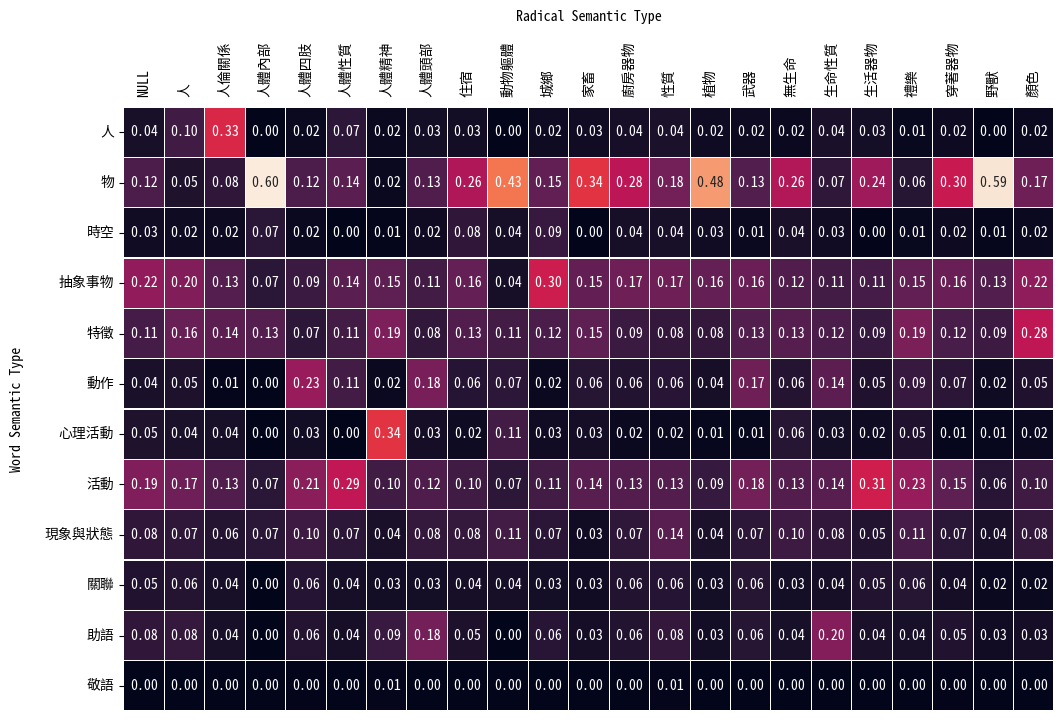

In [7]:
# np.sum(DTM.np, axis=0).shape
plt.figure(figsize=(12, 8), dpi=100)
P_givenFeat = DTM.count_mat / np.sum(DTM.count_mat, axis=0)
heatmap(P_givenFeat)

#### $P(Radical Type|Lexical Group)$

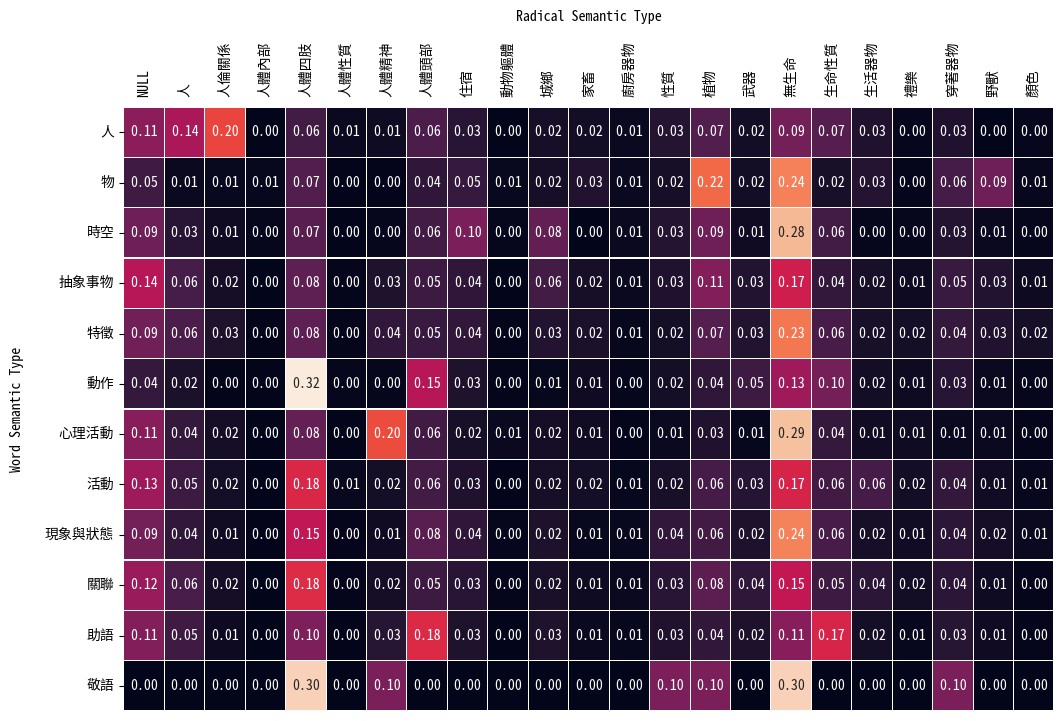

In [8]:
plt.figure(figsize=(12, 8), dpi=100)
P_givenDoc = (DTM.count_mat.T / np.sum(DTM.count_mat, axis=1)).T
heatmap(P_givenDoc)

#### Tf-IDF Matrix (single-character words)

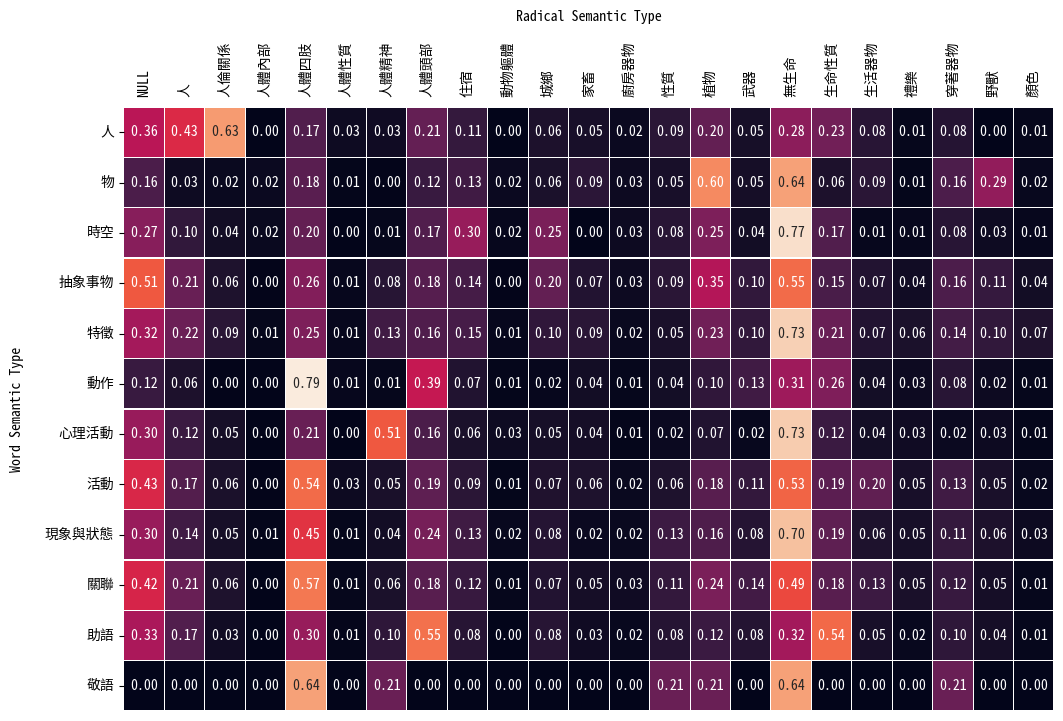

In [9]:
plt.figure(figsize=(12, 8), dpi=100)
P_tfidf = DTM.np
heatmap(P_tfidf)

In [10]:
DTM = DocumentTermMatrix(RSTagger=Tagger, Cilin=C, level=3)
df_feat, df_tgt = DTM.pd, DTM.df_tgt

In [11]:
pd.DataFrame(DTM.np, index=DTM.documents, columns=DTM.features)

,NULL,人,人倫關係,人體內部,人體四肢,人體性質,人體精神,人體頭部,住宿,動物軀體,城鄉,家畜,廚房器物,性質,植物,武器,無生命,生命性質,生活器物,禮樂,穿著器物,野獸,顏色
Aa01,0.406219,0.308751,0.406144,0.0,0.081704,0.0,0.000000,0.204047,0.449845,0.0,0.000000,0.000000,0.0,0.124908,0.268748,0.000000,0.070207,0.410127,0.251147,0.0,0.000000,0.0,0.0
Aa02,0.228373,0.433944,0.570828,0.0,0.000000,0.0,0.185307,0.430175,0.000000,0.0,0.172835,0.000000,0.0,0.175555,0.000000,0.177763,0.197350,0.288213,0.000000,0.0,0.000000,0.0,0.0
Aa03,0.434502,0.183471,0.000000,0.0,0.000000,0.0,0.470086,0.181878,0.000000,0.0,0.000000,0.270102,0.0,0.000000,0.159700,0.000000,0.625794,0.182784,0.000000,0.0,0.000000,0.0,0.0
Aa04,0.535627,0.678515,0.446274,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.231432,0.000000,0.000000,0.0,0.000000,0.0,0.0
Aa05,0.843837,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.310149,0.437889,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
La02,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
La03,0.000000,0.000000,0.000000,0.0,0.469357,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.717546,0.514618,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
La04,0.000000,0.000000,0.000000,0.0,0.778462,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.334462,0.000000,0.000000,0.0,0.531161,0.0,0.0
La05,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.882661,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.470011,0.000000,0.000000,0.0,0.000000,0.0,0.0


### (Multinomial) Naive Bayes Classifier

In [12]:
from sklearn.naive_bayes import MultinomialNB

df_feat, df_tgt = DTM.pd, DTM.df_tgt
X_train, X_test, y_train, y_test = train_test_split(
    df_feat, df_tgt, tgt_col="lev1", test_size = 0.5, random_state = 20
)

model = MultinomialNB(alpha=0.001)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print("Not predicted:", sorted(set(y_train) - set(predictions)))
classification_report(y_test, predictions)

Not predicted: ['C 時空', 'F 動作', 'I 現象與狀態', 'J 關聯', 'L 敬語']


,precision,recall,f1-score,support
A 人,0.484848,0.266667,0.344086,60.000000
B 物,0.430000,0.716667,0.537500,120.000000
C 時空,0.000000,0.000000,0.000000,30.000000
D 抽象事物,0.184211,0.080460,0.112000,87.000000
E 特徵,0.291667,0.077778,0.122807,90.000000
F 動作,0.000000,0.000000,0.000000,29.000000
G 心理活動,0.375000,0.136364,0.200000,22.000000
H 活動,0.300505,0.804054,0.437500,148.000000
I 現象與狀態,0.000000,0.000000,0.000000,64.000000
J 關聯,0.000000,0.000000,0.000000,22.000000


#### Permutation Importance: Selecting Important Features

In [13]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, precision_score, recall_score, accuracy_score, r2_score

# df_feat, df_tgt = DTM.pd, DTM.df_tgt
X_train, X_test, y_train, y_test = train_test_split(
    df_feat, df_tgt, tgt_col="lev1", test_size = 0.5, random_state = 20
)

scoring = {
    'recall': make_scorer(recall_score, average='weighted'),
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),
    'accuracy': make_scorer(accuracy_score),
    'f1': 'f1_weighted',
}
imps = permutation_importance(model, X_test, y_test, scoring=scoring, #'f1_micro',  #scoring, #['f1_micro', 'accuracy'],
                              n_repeats=2, n_jobs=-1, random_state=100)

In [14]:
importances = imps['f1']['importances_mean']
# std = imps['f1']['importances_std']

# model.score(X_test, y_test)
indices = np.argsort(importances)[::-1]

df_importance = []
# Print the feature ranking
# features = list(df_feat.columns)
for i in range(X_test.shape[1]):
    df_importance.append(
        ( 
          imps['accuracy']['importances_mean'][i],
          imps['f1']['importances_mean'][i],
          imps['precision']['importances_mean'][i],
          imps['recall']['importances_mean'][i],
        )
    )
df_importance = pd.DataFrame(df_importance, index=df_feat.columns, 
                             columns=['accuracy', 'f1', 'precision', 'recall'])
df_importance

,accuracy,f1,precision,recall
NULL,-0.002104,-0.002106,-0.002693,-0.002104
人,0.012623,0.012251,0.008774,0.012623
人倫關係,0.023843,0.024666,0.026733,0.023843
人體內部,0.002805,0.001484,0.000611,0.002805
人體四肢,0.031557,0.028895,0.022279,0.031557
人體性質,0.003506,0.002787,0.002049,0.003506
人體精神,0.030856,0.029688,0.039878,0.030856
人體頭部,0.009116,0.014226,-0.000815,0.009116
住宿,0.002104,0.000062,-0.046108,0.002104
動物軀體,0.005610,0.004253,0.004957,0.005610


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5]), <a list of 23 Text major ticklabel objects>)

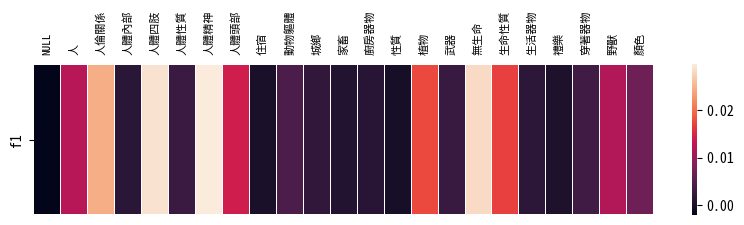

In [15]:
plt.figure(figsize=(10, 2), dpi=100)
sns.heatmap(df_importance[['f1']].T, xticklabels=True, linewidths=0.01, linecolor='white', 
                 cbar_kws=dict(orientation='vertical', aspect=35, pad=0.05))
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, 
                bottom=False, top = False, labeltop=True)
plt.xticks(rotation=90, fontsize=8)

In [16]:
df_importance_selected = df_importance.copy()

#### Feature importance of each class

In [17]:
from copy import deepcopy

df_feat, df_tgt = DTM.pd, DTM.df_tgt
X_train, X_test, y_train, y_test = train_test_split(
    df_feat, df_tgt, tgt_col="lev1", test_size = 0.5, random_state = 20
)

# Base model
model = MultinomialNB(alpha=0.001)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
# print("Not predicted:", sorted(set(y_train) - set(predictions)))
scores = classification_report(y_test, predictions, pandas=False)
baseScore = deepcopy(scores)

In [18]:
from sklearn.metrics import make_scorer, precision_score, recall_score, accuracy_score, f1_score

scoreDiff = {}
rmFeat = []
for col in df_importance_selected.index:
    # X_train_drop, X_test_drop = X_train.drop(columns=[col]), X_test.drop(columns=[col])
    # Shuffle
    X_train_drop, X_test_drop = X_train.copy(deep=True), X_test.copy(deep=True)
    X_train_drop[col] = X_train_drop[col].sample(frac=1, random_state=100).values
    X_test_drop[col] = X_test_drop[col].sample(frac=1, random_state=100).values
    # df1['HS_FIRST_NAME'] = df[4].sample(frac=1).values

    rmFeat.append(col)
    model = MultinomialNB(alpha=0.001)
    model.fit(X_train_drop, y_train)
    predictions = model.predict(X_test_drop)
    # print("Not predicted:", sorted(set(y_train) - set(predictions)))
    scores = classification_report(y_test, predictions, pandas=False)

    for cls, val in scores.items():
        # scoreDiff.setdefault(cls, [])
        if cls == 'accuracy':
            continue
            if 'accuracy' not in scoreDiff:
                scoreDiff['accuracy'] = []
            scoreDiff['accuracy'].append(baseScore['accuracy']- val)
        else:
            for stat, val in val.items():
                base_val = baseScore[cls][stat]
                k = f"{cls}_{stat}"
                if any(x in k for x in 'support macro weighted'.split()): continue
                if "f1" not in k: continue  # use F1 score only
                if k not in scoreDiff:
                    scoreDiff[k] = []
                scoreDiff[k].append(base_val - val)

df = pd.DataFrame(scoreDiff, index=rmFeat)

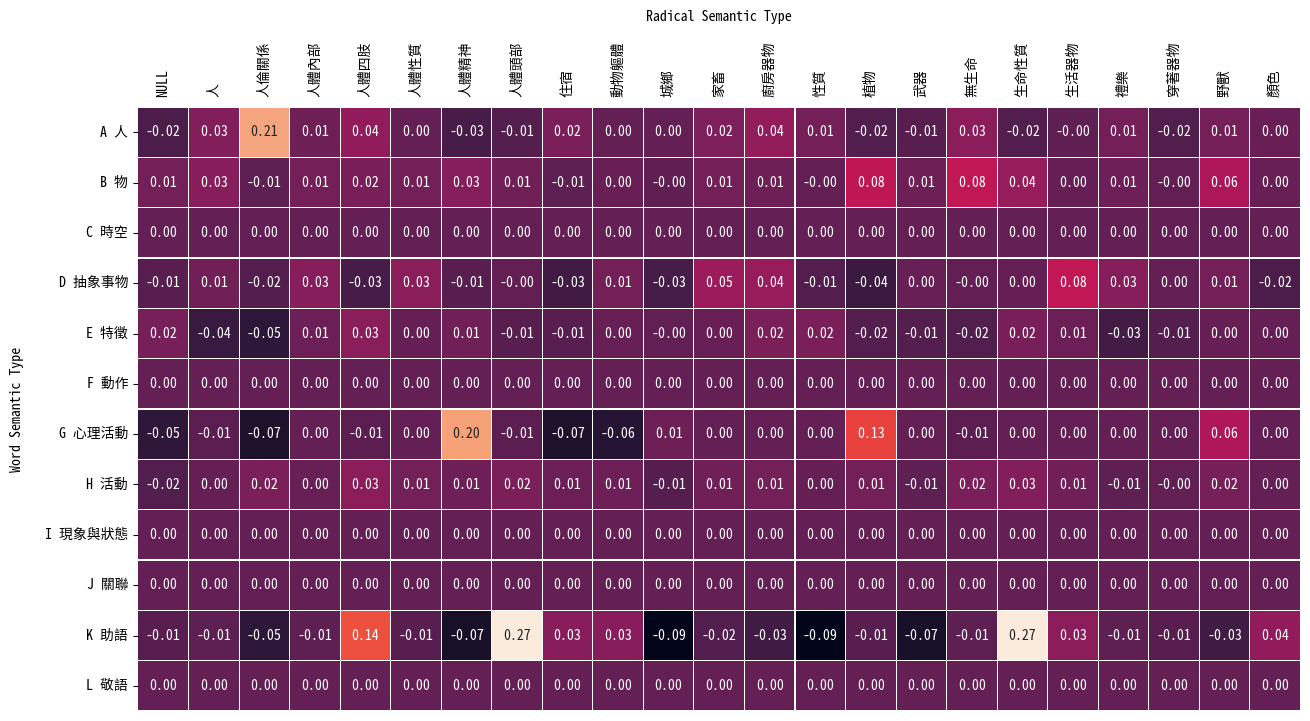

In [19]:
plt.figure(figsize=(15, 8), dpi=100)

dfT = df.T
dfT.rename(index={x: x.split('_')[0] for x in dfT.index }, inplace=True)
heatmap(dfT)

## Two-Character Words

ToDo: filter features with a frequency threshold

In [20]:
def heatmap(mat):
    dfT = pd.DataFrame(mat, index=rows)
    # sns.heatmap(dfT.T)
    ax = sns.heatmap(dfT.T, xticklabels=True, #linewidths=0.00, linecolor='white', 
                     # cbar_kws=dict(orientation='horizontal', aspect=35, pad=0.05)
                    )
    plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, 
                    bottom=False, top = False, labeltop=True)
    # plt.xticks(rotation=90, fontsize=8)
    # plt.show()

In [21]:
Tagger = RadicalSemanticTagger(all_words=all_words(), bigram=True, word_type="double")
DTM = DocumentTermMatrix(RSTagger=Tagger, Cilin=C, level=1)

feat_fq = np.sum(DTM.count_mat, axis=0)

In [22]:
# plt.hist(, bins=500)
def top_feats(fq_thresh, return_idx=False):
    feats = []
    for i, fq in enumerate(feat_fq):
        if fq >= fq_thresh:
            if return_idx:
                feats.append(i)
            else:
                feats.append(DTM.features[i])
    return feats

top_feats(500)

['NULL_NULL',
 'NULL_人體四肢',
 'NULL_植物',
 'NULL_無生命',
 '人_無生命',
 '人體四肢_NULL',
 '人體四肢_人體四肢',
 '人體四肢_植物',
 '人體四肢_無生命',
 '人體頭部_無生命',
 '植物_植物',
 '植物_無生命',
 '無生命_NULL',
 '無生命_人體四肢',
 '無生命_人體頭部',
 '無生命_植物',
 '無生命_無生命',
 '生命性質_無生命']

### Naive Bayes Classifier

In [23]:
from sklearn.naive_bayes import MultinomialNB

DTM = DocumentTermMatrix(RSTagger=Tagger, Cilin=C, level=3)

df_feat, df_tgt = DTM.pd, DTM.df_tgt
X_train, X_test, y_train, y_test = train_test_split(
    df_feat, df_tgt, tgt_col="lev1", test_size = 0.3, random_state = 20
)

model = MultinomialNB(alpha=0.001)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print("Not predicted:", sorted(set(y_train) - set(predictions)))
classification_report(y_test, predictions)

Not predicted: ['F 動作', 'J 關聯', 'L 敬語']


,precision,recall,f1-score,support
A 人,0.681818,0.416667,0.517241,36.000000
B 物,0.519608,0.736111,0.609195,72.000000
C 時空,0.500000,0.166667,0.250000,18.000000
D 抽象事物,0.222222,0.230769,0.226415,52.000000
E 特徵,0.311111,0.259259,0.282828,54.000000
F 動作,0.000000,0.000000,0.000000,17.000000
G 心理活動,0.384615,0.384615,0.384615,13.000000
H 活動,0.375758,0.696629,0.488189,89.000000
I 現象與狀態,0.250000,0.051282,0.085106,39.000000
J 關聯,0.000000,0.000000,0.000000,13.000000


#### Permutation Importance: Selecting Important Features

In [24]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, precision_score, recall_score, accuracy_score, r2_score

X_train, X_test, y_train, y_test = train_test_split(
    df_feat, df_tgt, tgt_col="lev1", test_size = 0.5, random_state = 20
)

scoring = {
    'recall': make_scorer(recall_score, average='weighted'),
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),
    'accuracy': make_scorer(accuracy_score),
    'f1': 'f1_weighted',
}
imps = permutation_importance(model, X_test, y_test, scoring=scoring, #'f1_micro',  #scoring, #['f1_micro', 'accuracy'],
                              n_repeats=2, n_jobs=-1, random_state=100)


importances = imps['f1']['importances_mean']
indices = np.argsort(importances)[::-1]

df_importance = []
# Print the feature ranking
# features = list(df_feat.columns)
for i in range(X_test.shape[1]):
    df_importance.append(
        ( 
          imps['accuracy']['importances_mean'][i],
          imps['f1']['importances_mean'][i],
          imps['precision']['importances_mean'][i],
          imps['recall']['importances_mean'][i],
        )
    )
df_importance = pd.DataFrame(df_importance, index=df_feat.columns, 
                             columns=['accuracy', 'f1', 'precision', 'recall'])

In [25]:
df_importance_selected = df_importance[df_importance > 0].dropna(axis=0, how='any')

In [26]:
idx = { x for x in top_feats(50, return_idx=False) if 'NULL' not in x }
idx = df_importance_selected.index.isin(idx)
df_importance_selected = df_importance[df_importance > 0].dropna(axis=0, how='any')
df_importance_selected = df_importance_selected[idx]
df_importance_selected

,accuracy,f1,precision,recall
人_人體四肢,0.004208,0.003031,0.003386,0.004208
人_人體精神,0.001403,0.002200,0.001986,0.001403
人_住宿,0.001403,0.001253,0.003999,0.001403
人_城鄉,0.000701,0.000711,0.001464,0.000701
人_性質,0.000701,0.000793,0.000305,0.000701
...,...,...,...,...
野獸_家畜,0.000701,0.001006,0.001046,0.000701
野獸_植物,0.002805,0.003000,0.002863,0.002805
野獸_無生命,0.000701,0.000779,0.000898,0.000701
野獸_野獸,0.002805,0.004741,0.002554,0.002805


#### Feature Importance of Each class

In [27]:
from copy import deepcopy

df_feat, df_tgt = DTM.pd, DTM.df_tgt
X_train, X_test, y_train, y_test = train_test_split(
    df_feat, df_tgt, tgt_col="lev1", test_size = 0.5, random_state = 20
)

# Base model
model = MultinomialNB(alpha=0.001)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
# print("Not predicted:", sorted(set(y_train) - set(predictions)))
scores = classification_report(y_test, predictions, pandas=False)
baseScore = deepcopy(scores)

In [28]:
from sklearn.metrics import make_scorer, precision_score, recall_score, accuracy_score, f1_score

scoreDiff = {}
rmFeat = []
for col in df_importance_selected.index:
    # X_train_drop, X_test_drop = X_train.drop(columns=[col]), X_test.drop(columns=[col])
    # Shuffle
    X_train_drop, X_test_drop = X_train.copy(deep=True), X_test.copy(deep=True)
    X_train_drop[col] = X_train_drop[col].sample(frac=1, random_state=100).values
    X_test_drop[col] = X_test_drop[col].sample(frac=1, random_state=100).values
    # df1['HS_FIRST_NAME'] = df[4].sample(frac=1).values

    rmFeat.append(col)
    model = MultinomialNB(alpha=0.001)
    model.fit(X_train_drop, y_train)
    predictions = model.predict(X_test_drop)
    # print("Not predicted:", sorted(set(y_train) - set(predictions)))
    scores = classification_report(y_test, predictions, pandas=False)

    for cls, val in scores.items():
        # scoreDiff.setdefault(cls, [])
        if cls == 'accuracy':
            if 'accuracy' not in scoreDiff:
                scoreDiff['accuracy'] = []
            scoreDiff['accuracy'].append(baseScore['accuracy']- val)
        else:
            for stat, val in val.items():
                base_val = baseScore[cls][stat]
                k = f"{cls}_{stat}"
                if any(x in k for x in 'support macro weighted'.split()): continue
                if k not in scoreDiff:
                    scoreDiff[k] = []
                scoreDiff[k].append(base_val - val)

df = pd.DataFrame(scoreDiff, index=rmFeat)

In [29]:
DTM_all = DocumentTermMatrix(RSTagger=Tagger, Cilin=C, level=1)
documents = [f"{x} {C.get_tag(x)}" for x in DTM_all.documents]
selected_feat_idx = [DTM_all.features.index(x) for x in df_importance_selected.index]
selected_feat_idx
count_mat = np.take(DTM_all.count_mat, selected_feat_idx, axis=1)

def heatmap2(mat):
    if isinstance(mat, np.ndarray):
        dfT = pd.DataFrame(mat, index=documents, columns=df_importance_selected.index)
    else:
        dfT = mat
        # dfT = df.filter(like='f1').T
        # dfT.rename(index={x: x.split('_')[0] for x in dfT.index }, inplace=True)
    ax = sns.heatmap(dfT, xticklabels=True, linewidths=0.01, linecolor='white', 
                     #annot=True, fmt='.2f', cbar=False,
                     cbar_kws=dict(orientation='horizontal', aspect=35, pad=0.05))
    ax.xaxis.set_label_position('top')
    plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, 
                    bottom=False, top = False, labeltop=True)
    plt.xticks(rotation=90); plt.yticks(rotation=0)
    plt.xlabel("Radical Semantic Type", labelpad=15); plt.ylabel("Word Semantic Type", labelpad=15)
    plt.show()

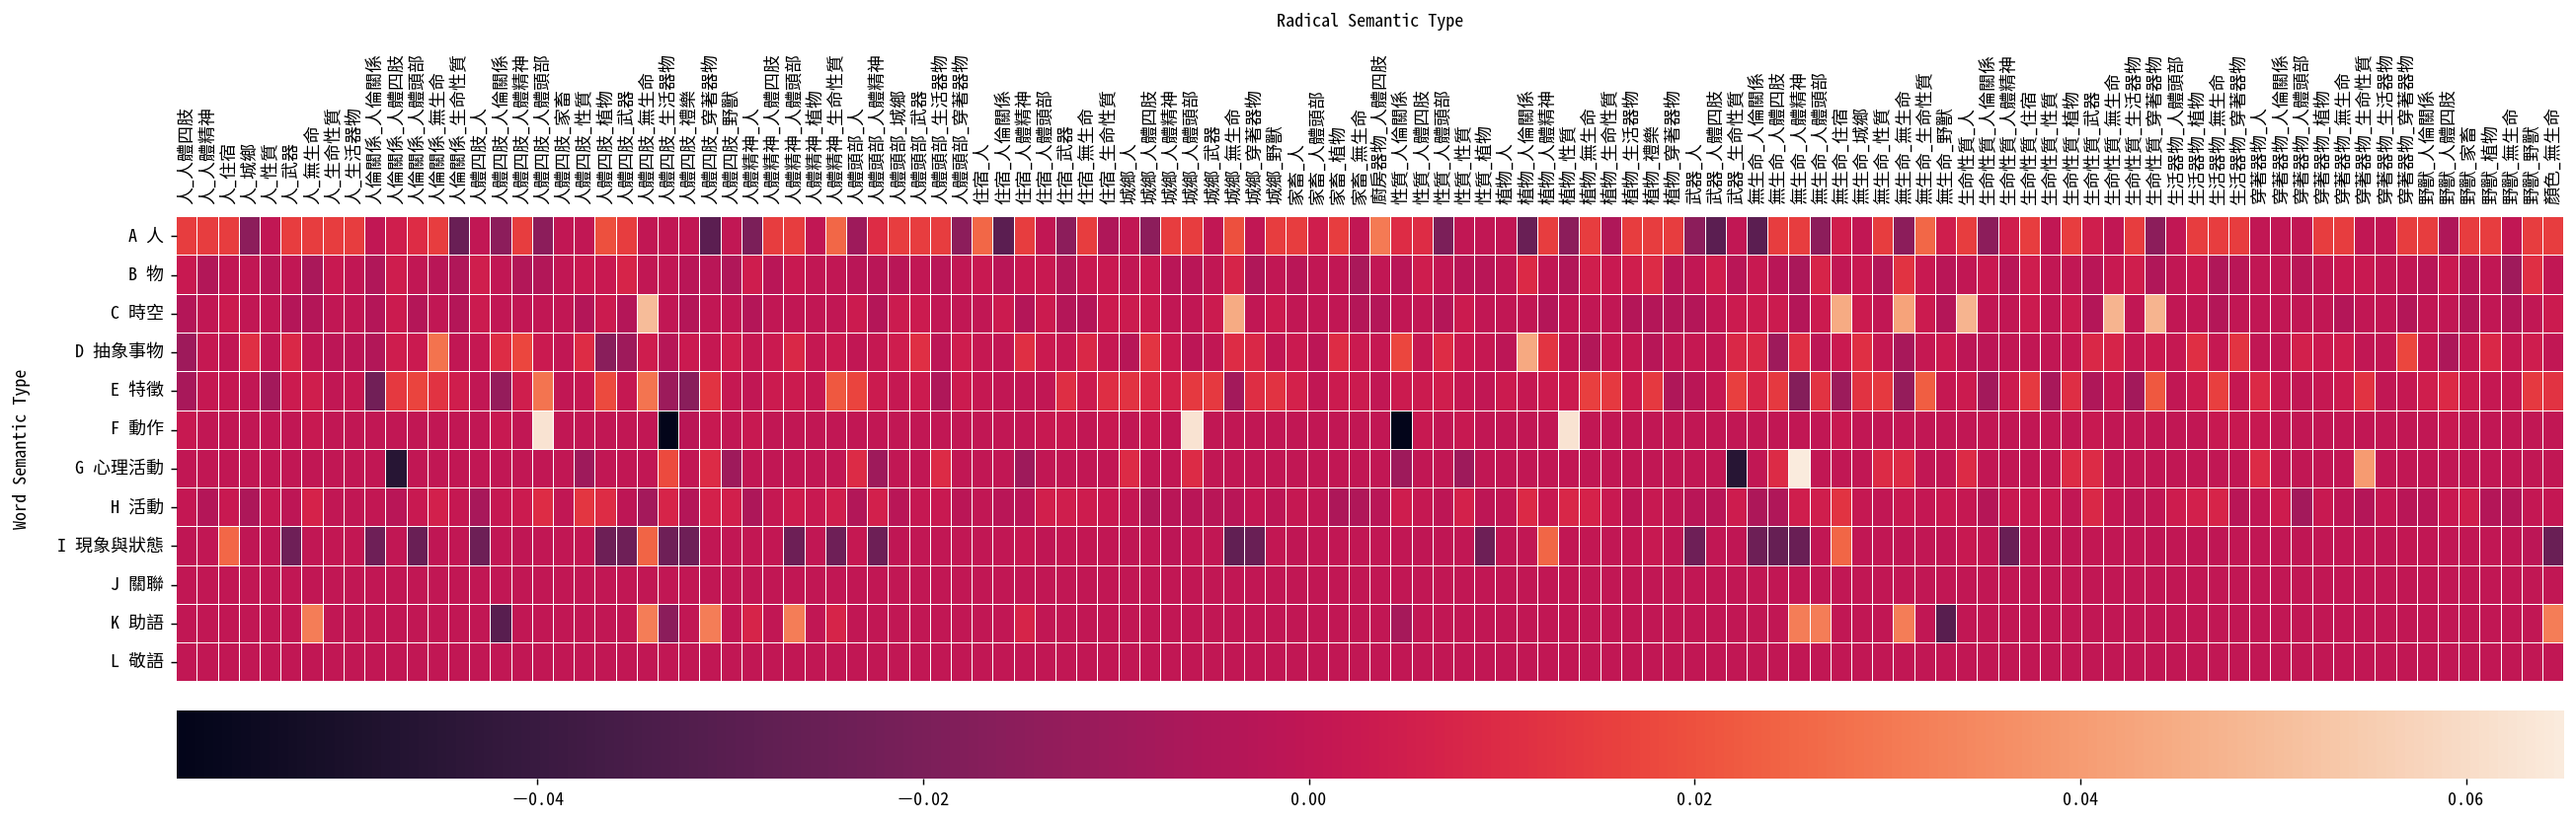

In [30]:
plt.figure(figsize=(24, 6), dpi=130)

dfT = df.filter(like='f1').T
dfT.rename(index={x: x.split('_')[0] for x in dfT.index }, inplace=True)
heatmap2(dfT)

In [31]:
Tagger = RadicalSemanticTagger(all_words=all_words(), bigram=True, word_type="double")

In [32]:
s1 = Tagger.tag2words.get('無生命_住宿')  # G: 無生命_人體精神  C: 人體四肢_無生命, 無生命_住宿   # F: 人體四肢_人體頭部, 城鄉_人體頭部 (drastic semantic change)
s2 = C.get_members('I')
s1.intersection(s2)

{'凌空',
 '填空',
 '墊底',
 '增容',
 '忽閃',
 '恢宏',
 '收尾',
 '改寫',
 '放寬',
 '放開',
 '散開',
 '昏厥',
 '暈厥',
 '暴富',
 '決定',
 '沉底',
 '泄密',
 '泄底',
 '泌尿',
 '煞尾',
 '燎原',
 '鋪展',
 '露底'}

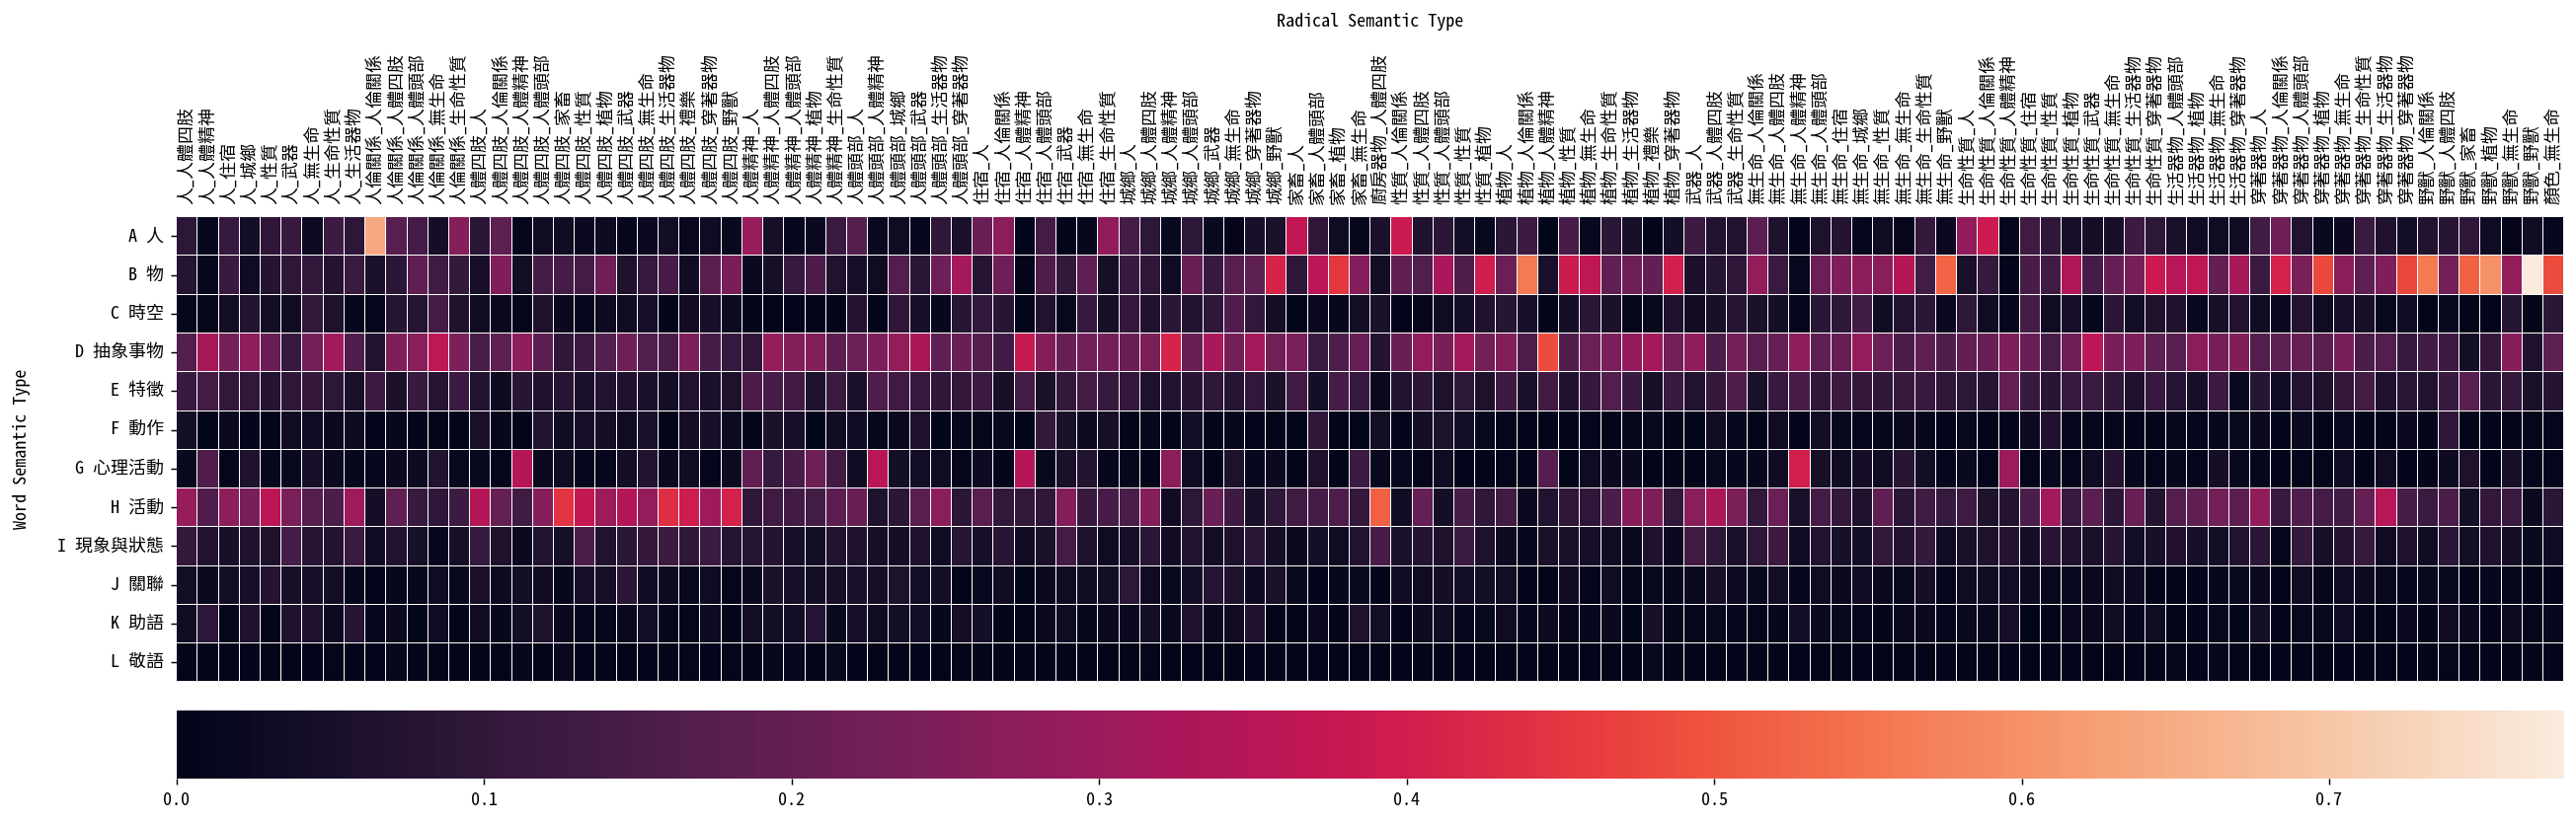

In [33]:
DTM_all = DocumentTermMatrix(RSTagger=Tagger, Cilin=C, level=1)
selected_feat_idx = [DTM_all.features.index(x) for x in df_importance_selected.index]
selected_feat_idx
count_mat = np.take(DTM_all.count_mat, selected_feat_idx, axis=1)

plt.figure(figsize=(24, 6), dpi=130)
P_givenFeat = count_mat / np.sum(count_mat, axis=0)
heatmap2(P_givenFeat)

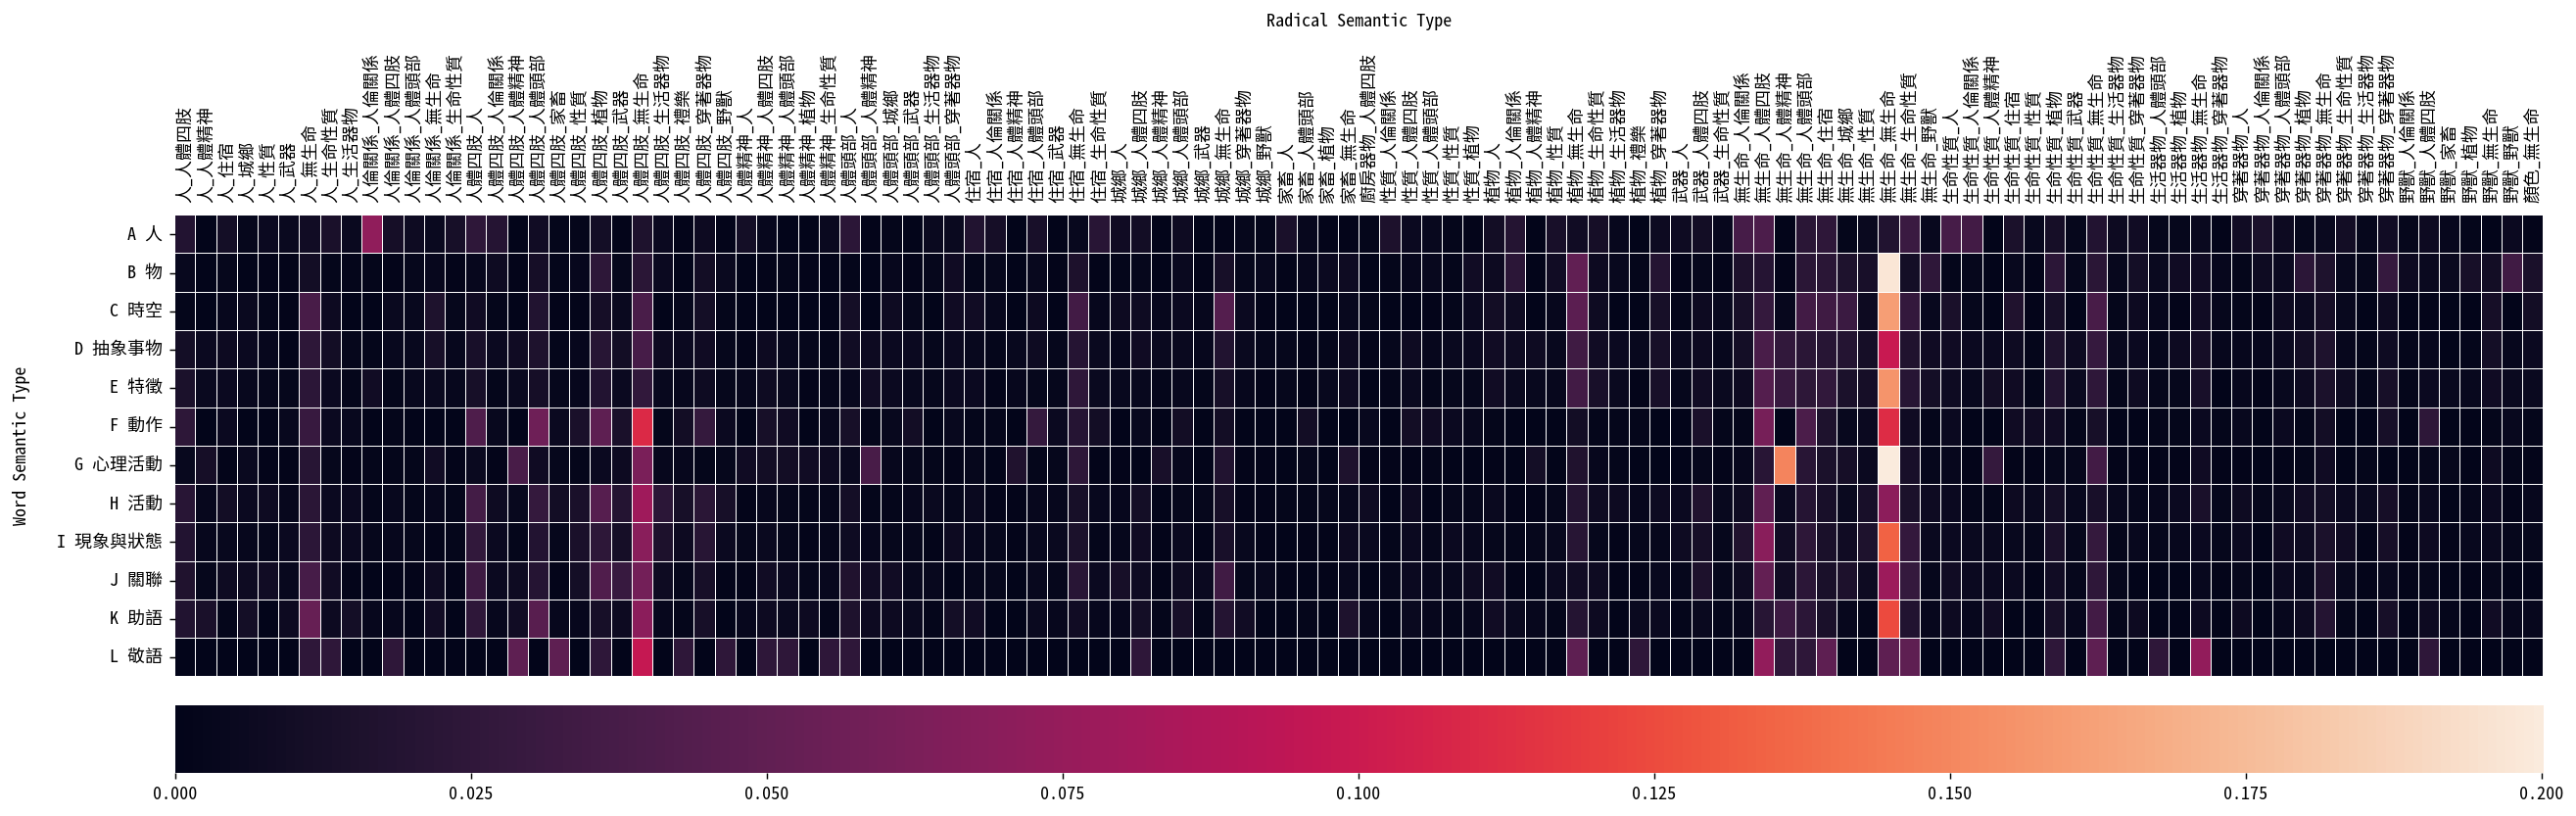

In [34]:
plt.figure(figsize=(24, 6), dpi=130)
P_givenDoc = (count_mat.T / np.sum(count_mat, axis=1)).T
heatmap2(P_givenDoc)

### Refit model with Top-245 important features (Model Checking)

Top-245 features should have a similar performance to the full model

In [35]:
df_importance_selected = df_importance[df_importance > 0].dropna(axis=0, how='any')
df_importance_selected

,accuracy,f1,precision,recall
NULL_NULL,0.003506,0.002197,0.004863,0.003506
NULL_人倫關係,0.001403,0.002424,0.003484,0.001403
NULL_人體內部,0.000701,0.000563,0.003671,0.000701
NULL_人體四肢,0.002104,0.001888,0.004345,0.002104
NULL_人體頭部,0.004208,0.003944,0.006812,0.004208
...,...,...,...,...
顏色_生活器物,0.000701,0.000440,0.000327,0.000701
顏色_禮樂,0.000701,0.001029,0.000977,0.000701
顏色_穿著器物,0.001403,0.001387,0.001392,0.001403
顏色_野獸,0.000701,0.001227,0.000664,0.000701


In [36]:
from random import sample, seed

seed(10)

rnd_acc_546feat, rnd_acc_314feat, rnd_acc_165feat, rnd_acc_rnd165feat = [], [], [], []
rnd_f1_546feat, rnd_f1_314feat, rnd_f1_165feat, rnd_f1_rnd165feat = [], [], [], []
acc_546feat, acc_314feat, acc_165feat, acc_rnd165feat = [], [], [], []
f1_546feat, f1_314feat, f1_165feat, f1_rnd165feat = [], [], [], []

sampled_feat = set(DTM.features) - set(df_importance_selected.index)  # sample(DTM.features, 114)
for i in range(150):
    df_feat, df_tgt = DTM.pd, DTM.df_tgt

    X_train, X_test, y_train, y_test = train_test_split(
        df_feat, df_tgt, tgt_col="lev1", test_size = 0.5, random_state = i
    )
    X_train_sm, X_test_sm = X_train[df_importance_selected.index], X_test[df_importance_selected.index]
    # X_train_sm2, X_test_sm2 = X_train[df_importance_selected2.index], X_test[df_importance_selected2.index]
    X_train_rnd, X_test_rnd = X_train[sampled_feat], X_test[sampled_feat]
    y_train_shuffle, y_test_shuffle = sample(y_train, len(y_train)),  sample(y_test, len(y_test))

    for xtrain, xtest, acc, f1, acc_rnd, f1_rnd in zip([X_train, X_train_sm, X_train_rnd], 
                                  [X_test, X_test_sm, X_test_rnd], 
                                  [acc_546feat, acc_165feat , acc_rnd165feat],
                                  [f1_546feat, f1_165feat, f1_rnd165feat],
                                  [rnd_acc_546feat, rnd_acc_165feat , rnd_acc_rnd165feat],
                                  [rnd_f1_546feat, rnd_f1_165feat, rnd_f1_rnd165feat]
                                  ):
        model = MultinomialNB(alpha=0.001)
        model.fit(xtrain, y_train)
        predictions = model.predict(xtest)
        acc.append(accuracy_score(y_test, predictions))
        f1.append(f1_score(y_test, predictions, average="weighted"))
        
        # model.fit(xtrain, y_train_shuffle)
        # predictions = model.predict(xtest)
        acc_rnd.append(accuracy_score(y_test_shuffle, predictions))
        f1_rnd.append(f1_score(y_test_shuffle, predictions, average="weighted"))

In [37]:
from statistics import stdev, median, mean

df = pd.DataFrame([
    ["523 feats (All)",          mean(acc_546feat),    stdev(acc_546feat),    mean(f1_546feat),    stdev(f1_546feat)],
    ["245 feats (Top)",          mean(acc_165feat),    stdev(acc_165feat),    mean(f1_165feat),    stdev(f1_165feat)],
    ["278 feats (Bottom)", mean(acc_rnd165feat), stdev(acc_rnd165feat), mean(f1_rnd165feat), stdev(f1_rnd165feat)],
], columns=['model', 'Acc.mean', 'Acc.std', 'F1.mean', 'F1.std' ])
df

,model,Acc.mean,Acc.std,F1.mean,F1.std
0,523 feats (All),0.396793,0.013960,0.358500,0.013268
1,245 feats (Top),0.384554,0.013749,0.327744,0.013233
2,278 feats (Bottom),0.329649,0.012330,0.279679,0.012518


In [38]:
# Random baseline (prediction labels shuffled)
df = pd.DataFrame([
    ["523 feats (All)",    mean(rnd_acc_546feat), stdev(rnd_acc_546feat), mean(rnd_f1_546feat), stdev(rnd_f1_546feat)],
    ["245 feats (Top)",    mean(rnd_acc_165feat), stdev(rnd_acc_165feat), mean(rnd_f1_165feat), stdev(rnd_f1_165feat)],
    ["278 feats (Bottom)", mean(rnd_acc_rnd165feat), stdev(rnd_acc_rnd165feat), mean(rnd_f1_rnd165feat), stdev(rnd_f1_rnd165feat)],
], columns=['model', 'Acc.mean', 'Acc.std', 'F1.mean', 'F1.std' ])
df

,model,Acc.mean,Acc.std,F1.mean,F1.std
0,523 feats (All),0.154923,0.011717,0.129377,0.010350
1,245 feats (Top),0.166872,0.012656,0.128833,0.010452
2,278 feats (Bottom),0.168939,0.013278,0.126390,0.011043
